## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [14]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [15]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [16]:
sc = SparkContext.getOrCreate()
sc.stop()

In [17]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [18]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [19]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBBSBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
947
+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|            coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+-------------------+------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|3645.7765262509515|   828.805477559964|499.76581228215304|     44.2|BBBBBSBS| 43.9869|  -70.055|       SNWD|0.15320659652172913|0.10944404825099076|0.09353183959148387| 0.4651969098

In [49]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_3|
+-----------+--------+---------+---------+-------------------+
|USC00172048| 43.9869|  -70.055|     44.2| 499.76581228215304|
|USC00276945| 43.7833|   -71.65|    201.2|  267.4168387387765|
|USC00176011| 43.8792| -70.6328|    106.7|  881.5044404755679|
|US1NHMR0025| 43.2115| -71.4143|    210.3|-1538.9836692991894|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [50]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_3)
68,CA008206500,43.833,-66.083,48.0,2,-560.775420
72,US1MECM0007,43.744,-70.489,44.8,1,-1244.592526


-1538.9836693 1021.05784193


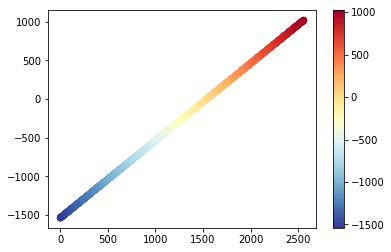

In [51]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max
# _min = 24.1429
# _max = 172.9380

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))
print _min, _max

x = range(0,-int(round(_min))+int(round(_max)))
y = range(int(round(_min)),int(round(_max)))
cm = plt.cm.get_cmap('RdYlBu_r') 
plt.figure()
plt.scatter(x, y,c=y, cmap = cm)
plt.colorbar()
plt.show()

#get_color(1000.)

## Map

In [52]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat,max_lat,min_long,max_long = box = (42.6408, 44.0303, -71.65, -69.2622)

In [53]:
### get station and vector
feat = "'SNWD'"
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT station, latitude,longitude,elevation,%s FROM weather where station in (SELECT DISTINCT(station) FROM weather)"%feature
#Query="SELECT MIN(latitude),MAX(latitude),MIN(longitude),MAX(longitude) FROM weather WHERE station!='CA008206500'"
Query = "SELECT station,vector FROM weather WHERE measurement=%s"%feat
print(Query)
df3 = sqlContext.sql(Query)
df3.show(5)

SELECT station,vector FROM weather WHERE measurement='SNWD'
+-----------+--------------------+
|    station|              vector|
+-----------+--------------------+
|USC00172048|[24 5F 90 60 90 6...|
|USC00276945|[C0 5E C4 60 C4 6...|
|USC00176011|[C4 5C F4 5D F4 5...|
|US1NHMR0025|[F0 57 C0 54 60 5...|
|USC00176011|[2A 60 C2 61 8E 6...|
+-----------+--------------------+
only showing top 5 rows



In [54]:
from collections import defaultdict
from numpy_pack import packArray,unpackArray
df4 = df3.rdd.map(lambda row:[row['station'],np.nanmean(unpackArray(row['vector'],np.float16),dtype='float64')])
total_snow_per_year=defaultdict(float)
for row in df4.collect():
    total_snow_per_year[row[0]] += row[1]

In [55]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom,
            legend_name='snow depth')

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

# minSnow = 99999999
# maxSnow = 0

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
#     _snow=total_snow_per_year[row['station']]/_count
#     if (_snow>maxSnow):
#         maxSnow = _snow
#     if (_snow<minSnow):
#         minSnow = _snow
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [ ]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [ ]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

In [ ]:
sc.stop()

In [ ]:
a=np.array([ 432.,  610.,  610.,  610.,  686.,  660.,  660.,  635.,  610.,
         610.,  610.,  610.,  610.,  711.,  686.,  686.,  686.,  635.,
         635.,  660.,  635.,  610.,  610.,  838.,  813.,  813.,  813.,
         787.,  787.,  787.,  787.,  787.,  787.,  787.,  762.,  762.,
         787.,  762.,  762.,  762.,  889.,  838.,  838.,  838.,  813.,
         787.,  787.,  762.,  762.,  762.,  864.,  813.,  813.,  813.,
         813.,  787.,  787.,  787.,  787.,  787.,  864.,  838.,  787.,
         864.,  864.,  838.,  914.,  914.,  940.,  965.,  914.,  864.,
         813.,  787.,  787.,  787.,  787.,  762.,  737.,  737.,  787.,
         737.,  711.,  711.,  686.,  660.,  635.,  610.,  610.,  584.,
         533.,  533.,  508.,  508.,  508.,  483.,  762.,  483.,  457.,
         457.,  432.,  483.,  381.,  381.,  381.,  330.,  305.,  229.,
         203.,  102.,   51.,   51.,   51.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   25.,   25.,   25.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   25.,   25.,   25.,   51.,   51.,   25.,
           0.,    0.,    0.,    0.,    0.],np.float32)

In [ ]:
np.sum(a)

In [ ]:
help (plt.colorbar)